# Ambulance Posting Project

1. [Problem Description](#Problem-Description)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   1. [Removing Non\-Response and Non\-EMS Incidents](#Removing-Non-Response-and-Non-EMS-Incidents)
   2. [Further Indications of No Meaningful Response](#Further-Indications-of-No-Meaningful-Response)
   3. [Removing Mutual Aid Calls](#Removing-Mutual-Aid-Calls)
   4. [Standardizing Incident Types](#Standardizing-Incident-Types)
   5. [Removing Non\-Useful Incident Types](#Removing-Non-Useful-Incident-Types)
   6. [Priority Level](#Priority-Level)
   7. [Actual Response Time](#Actual-Response-Time)
   8. [Incident Distribution Over Time](#Incident-Distribution-Over-Time)
   9. [Heatmap Animated by Month](#Heatmap-Animated-by-Month)
3. [Modeling](#Modeling)
   1. [Model Selection](#Model-Selection)
   2. [Model Features: Geospatial Data](#Model-Features:-Geospatial-Data)
   3. [Sample Weighting](#Sample-Weighting)
   4. [Defining a Response Time Metric](#Defining-a-Response-Time-Metric)
   5. [AmbulancePostOptimizer Class](#AmbulancePostOptimizer-Class)
   6. [Test/Train Split](#Train/Test-Split)
   7. [Get Baseline Metrics](#Get-Baseline-Metrics)
   8. [Evaluating ERT as a Metric](#Evaluating-ERT-as-a-Metric)
   9. [Standard KMeans Model Optimization](#Standard-KMeans-Model-Optimization)
   10. [Bisecting KMeans Model Optimization](#Bisecting-KMeans-Model-Optimization)
   11. [Lambda Value](#Lambda-Value)
4. [Model Evaluation](#Model-Evaluation)
   1. [Box Plots of Estimated Response Times by Post \(Cluster\)](#Box-Plots-of-Estimated-Response-Times-by-Post-(Cluster))
   2. [Box Plots of Estimated Response Time by Priority](#Box-Plots-of-Estimated-Response-Time-by-Priority)
   3. [Cluster Maps of Coverage Areas](#Cluster-Maps-of-Coverage-Areas)
5. [Conclusions](#Conclusions)
   1. [Future Research](#Future-Research)



In [3]:
######### Imports ###############
# Retrieving and working with data
import os
from urllib.request import urlretrieve
import urllib
import pandas as pd
import numpy as np
import random
import time
import re
from pathlib import Path
from scipy.stats import spearmanr, pearsonr
from scipy.interpolate import interp1d
import math

# Output & Visualization
from IPython.display import display
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import seaborn as sns
import folium
from folium.plugins import HeatMapWithTime

# Geodata and networking
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import networkx as nx

# scikit learn & scikit opt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, BisectingKMeans
from skopt import gp_minimize
from skopt.space import Real, Integer

# Parallel processing
from joblib import Parallel, delayed
import multiprocessing as mp

## Problem Description

For my project, I wanted to explore problems related to emergency management. An interesting problem where unsupervised learning could be useful is in making ambulance posting location decisions.

Every second counts when an ambulance responds to an emergency. Delayed arrivals are directly linked to negative patient outcomes. However, municipalities operate with finite ambulance resources.  Strategically positioning these limited resources – determining their standby "posts" – is crucial. Inefficient posting can drastically increase response times.

This project will use a dataset of EMS responses from a public municipality and suggest optimized mobile posting locations. The model's performance will be evaluated by comparing estimated response times from its recommended posts against those with current posting strategies.

[This project is available on Github.](https://github.com/katlabs/ambulance-posting)



## Exploratory Data Analysis

### Data Sourcing

The dataset I will use for this project is the [Cincinnati Fire Incidents \(CAD\) \(including EMS: ALS/BLS\)](https://data.cincinnati-oh.gov/Safety/Cincinnati-Fire-Incidents-CAD-including-EMS-ALS-BL/vnsz-a3wp/about_data) dataset from the city of Cincinnati website's Open Data. The page for the dataset has an overview and preview of the dataset, as well as 3 PDFs that further describe the usages of each field.

Because the website has a data preview and uses the [Socrata API](https://dev.socrata.com/foundry/data.cincinnati-oh.gov/vnsz-a3wp), which allows SQL\-like querying, I can limit the dataset before I download it locally.

#### Location Columns

Browsing the dataset, I notice that there are rows with null values for **latitude\_x** and **longitude\_x**. I know that my problem will focus on precise locations of incidents given by these two columns. Although there are other location fields, such as **neighborhood**, **beat** and **address\_x**, these are not precise enough to create models that will meaningfully relate locations to response times. The **address\_x** column is given without a street number as a privacy practice, and determining a location point by street name alone can vary greatly. Therefore, I will limit the dataset to incidents that have values for **latitude\_x** and **longitude\_x**. Although I won't be using the **address\_x** column directly for modeling, it might be useful to check it when working with the data for sanity checking the coordinates, so I will download it as well.

#### Datetime Columns

The dataset contains incidents from 2015 to present. There are four datetime columns: **create\_time\_incident**, **dispatch\_time\_primary\_unit**, **arrival\_time\_primary\_unit**, **closed\_time\_incident**. Each represents a step in the process of responding to a call. The **create\_time\_incident** column can be used as the main datetime column. The **arrival\_time\_primary\_unit** column can be subtracted from the **dispatch\_time\_primary\_unit** column to get an actual response time. The **closed\_time\_incident** column can be used to filter calls that likely did not receive a response, such as erroneous entries, if the incident was created and closed within a short period of time. If there is no value for **dispatch\_time\_primary\_unit**, we can assume the call was not dispatched.

Since the data ranges over 9 years, it may be a good idea to limit the data to a shorter time frame. I will download entries from the past five years. I should also limit how recent the data is so that the notebook produces the same results, even when run in the future. If I limit the data set to entries with **create\_time\_incident** between Jan 2019 and Dec 2024, I can achieve these goals and ensure that each incident has a value for its main datetime column.

#### Incident Description Columns

The **incident\_type\_id** column is the main code used to categorize the type of incident that occurred. The **incident\_type\_desc** column is a description of the incident type. The **disposition\_text** describes how the call was cleared, and usually gives some sort of result, such as if a patient was transported. According to the [Cincinnati Fire Incidents \(CAD\) Data Dictionary PDF](https://data.cincinnati-oh.gov/api/views/vnsz-a3wp/files/b149e911-467c-4828-9701-434e95cded55?download=true&filename=Cincinnati%20Fire%20Incidents%20(CAD)%20Data%20Dictionary.pdf), the **cfd\_incident\_type** column is one of: ALS \(Advance Life Service\), BLS \(Basic Life Service\), FIRE \(fire incident\), MEDI \(Medical Service Provided\), OTHE \(service provided by CFD but are not classified as a fire response\), and NULL \(usually an ALS response of a combined incident type not captured by the system\). The **cfd\_incident\_type\_group** is a high\-level description of the incident. Each of these columns can be useful in determining whether the incident should be included in the final dataset for modeling, as well as any sort of feature engineering for a priority level.

#### Data Limitations & Challenges

- The **latitude\_x** and **longitude\_x** columns have been systematically randomly skewed slightly to protect privacy.
- The incident types are a mixture of MPDS \(Medical Priority Dispatch\), FPDS \(Fire Priority Dispatch\) and custom codes unique to the Cincinnati Fire Department, including codes representing a combined response. If I want to create a feature from these codes, it will be limited by my interpretation and domain knowledge. I may have to make some assumptions that could be false.
- I may not be able to account for all errors that have occurred in the process of entering each entry.

Given these limitations, very specific conclusions may not be completely accurate. However, the scope of this project is mainly theoretical, and the limitations are not such that I cannot create a valid proof\-of\-concept, or even some interesting insights about this specific dataset.

In [4]:
# Define columns
column_dtypes = {
    'latitude_x': np.float64, 'longitude_x': np.float64,
    'incident_type_id': str, 'incident_type_desc': str, 'disposition_text': str, 
    'cfd_incident_type': str, 'cfd_incident_type_group': str, 'address_x': str,
    'beat': str, 
}

dt_columns= ['create_time_incident', 'dispatch_time_primary_unit', 'arrival_time_primary_unit', 'closed_time_incident']

In [5]:
def make_dataset_query_url(start_date, end_date, columns):
    base_url = "https://data.cincinnati-oh.gov/resource/vnsz-a3wp.csv"
    select_clause = ", ".join(columns)
    where_clause = (
        f"create_time_incident >= '{start_date}T00:00:00' AND "
        f"create_time_incident <= '{end_date}T23:59:59' AND "
        "latitude_x IS NOT NULL AND longitude_x IS NOT NULL"
    )
    order_by_clause = "create_time_incident"
    limit_clause = "1000000"

    query = (
        f"SELECT {select_clause} "
        f"WHERE {where_clause} "
        f"ORDER BY {order_by_clause} "
        f"LIMIT {limit_clause}"
    )

    # Construct the full URL
    cfd_url = f"{base_url}?$query={query}"

    # Encode the URL
    encoded_url = urllib.parse.quote(cfd_url, safe="/:$'=?,-", encoding='utf-8', errors='replace')
    return encoded_url

In [6]:
# Get data for 5 years
start_date = '2019-01-01'
end_date = '2024-12-31'
cfd_path = f"data/cfd_data_{start_date}_{end_date}.csv"

# Download the dataset if it is not already downloaded
if os.path.isfile(cfd_path):
    print("Dataset already exists, skipping download...")
else:
    print("Downloading dataset... ")
    cfd_url = make_dataset_query_url(start_date, end_date, dt_columns + list(column_dtypes.keys()))
    urlretrieve(cfd_url, cfd_path)

df = pd.read_csv(cfd_path, parse_dates=dt_columns, date_format="%Y-%m-%dT%H:%M:%S.%f", dtype=column_dtypes)
df.info()
display(df.head())

Dataset already exists, skipping download...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547712 entries, 0 to 547711
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   create_time_incident        547712 non-null  datetime64[ns]
 1   dispatch_time_primary_unit  499716 non-null  datetime64[ns]
 2   arrival_time_primary_unit   474427 non-null  datetime64[ns]
 3   closed_time_incident        533247 non-null  datetime64[ns]
 4   latitude_x                  547712 non-null  float64       
 5   longitude_x                 547712 non-null  float64       
 6   incident_type_id            543756 non-null  object        
 7   incident_type_desc          417247 non-null  object        
 8   disposition_text            541782 non-null  object        
 9   cfd_incident_type           390103 non-null  object        
 10  cfd_incident_type_group     417198 non-null  object        
 11  address_x                   547638 non-

,create_time_incident,dispatch_time_primary_unit,arrival_time_primary_unit,closed_time_incident,latitude_x,longitude_x,incident_type_id,incident_type_desc,disposition_text,cfd_incident_type,cfd_incident_type_group,address_x,beat
0,2019-01-01 00:00:44,2019-01-01 00:01:01,2019-01-01 00:04:16,NaT,39.202702,-84.548237,ACCI-COMBINED,ACCIDENT WITH INJURIES (COMBINED),NaN,NaN,ACCIDENT WITH INJURY,W NORTH BEND RD,ST51
1,2019-01-01 00:02:36,2019-01-01 00:02:49,2019-01-01 00:06:59,NaT,39.144090,-84.496404,SHOOT-COMBINED,SHOOTING (COMBINED),NaN,ALS,SHOOTING HAS OCCURRED,HICKORY ST,ST32
2,2019-01-01 00:04:52,2019-01-01 00:05:15,2019-01-01 00:10:21,NaT,39.174174,-84.429047,SHOOT-COMBINED,SHOOTING (COMBINED),NaN,ALS,SHOOTING HAS OCCURRED,MAPLELEAF AV,ST08
3,2019-01-01 00:05:10,2019-01-01 00:06:17,NaT,NaT,39.203084,-84.538254,SHOOT-COMBINED,SHOOTING (COMBINED),NaN,ALS,SHOOTING HAS OCCURRED,WIONNA AV,ST51
4,2019-01-01 00:07:56,2019-01-01 00:09:05,NaT,NaT,39.157544,-84.596522,1A1,ABDOMINAL PAIN,NaN,BLS,ABDOMINAL PAIN / PROBLEMS,WESTWOOD NORTHERN BLVD,ST35


### Removing Non\-Response and Non\-EMS Incidents

Since this project is about optimizing ambulance posting locations, we want our dataset to only include calls that an EMS unit must physically respond to. The PDFs from the dataset website give us some helpful places to start for eliminating these types of incidents.

- The [CFD Data Visualization Exclusions PDF](https://data.cincinnati-oh.gov/api/views/vnsz-a3wp/files/332b352e-ed36-41ae-847f-0346be2588e2?download=true&filename=CFD%20Data%20Visualization%20Exclusions.pdf) documents values of certain fields that indicate entries where there was no response from the Cincinnati Fire Department. We can drop these rows from our dataset.
- The [Cincinnati Fire Incidents \(CAD\) Data Dictionary PDF](https://data.cincinnati-oh.gov/api/views/vnsz-a3wp/files/b149e911-467c-4828-9701-434e95cded55?download=true&filename=Cincinnati%20Fire%20Incidents%20(CAD)%20Data%20Dictionary.pdf) says that EMS responses For EMS responses have values ALS, BLS, NULL and MEDI in the **cfd\_incident\_type** field. The FIRE and OTHE fields are not EMS responses, so we can drop those.



In [7]:
# Eliminate rows that documentation says did not result in a response from CFD
disp_text_no_response = ['AV: ADVISED','AV: ADVISED,CN: CANCEL','AV: ADVISED,CN: CANCEL,SBY: ST','AV: ADVISED,DEF: DEFAULT','AV: ADVISED,DUPF: DUPLICATE','AV: ADVISED,FADV: FIRE ADVISED','AV: ADVISED,TTY: TELETYPED','CAN:CANCEL','CANCEL INCIDENT','CN: CANCEL','CN: CANCEL,AV: ADVISED','CN: CANCEL,DEF: DEFAULT','CN: CANCEL,DUPF: DUPLICATE','CN: CANCEL,DUPF: DUPLICATE,FAD','CN: CANCEL,FADV: FIRE ADVISED','CN: CANCEL,FD: FIRE DISREGARD','CN: CANCEL,REASF: REASSIGNED','CN: CANCEL,SBY: STANDBY','CN: CANCEL,TTY: TELETYPED','CN: CANCEL,TTY: TELETYPED,DEF:','DUPF: DUPLICATE','DUPF: DUPLICATE,AV: ADVISED','DUPF: DUPLICATE,CN: CANCEL','DUPF: DUPLICATE,CN: CANCEL,DEF','DUPF: DUPLICATE,DEF: DEFAULT','DUPF: DUPLICATE,EMS: NO TRANSP','DUPF: DUPLICATE,FADV: FIRE ADV','DUPF: DUPLICATE,FALA: FIRE FAL','DUPF: DUPLICATE,GI: GOOD INTEN','DUPF: DUPLICATE,MAL: SYSTEM MA','DUPF: DUPLICATE,MEDT: MEDIC TR','DUPF: DUPLICATE,TTY: TELETYPED','DUPLICATE INCIDENT','TTY: TELETYPED']
cfd_inc_type_no_response = ['FIRE ADVISED NO DISPATCH','FIRE DRILL NO RESPONSE','FIRE SERVICE NO DISPATCH/NOT USED','INFORMATION TELETYPE NO DISPATCH','NOT USED']

# Remove incidents with no-response disposition_text
df = df[~df['disposition_text'].isin(disp_text_no_response)]
print(f'Rows after dropping no response disposition_text values: {df.shape[0]}')

# Remove incidents with no-response cfd incident type group
df = df[~df['cfd_incident_type_group'].isin(cfd_inc_type_no_response)]
print(f'Rows after dropping no response cfd_incident_type_group values: {df.shape[0]}')

# Remove non-EMS responses (fire and other)
df = df[~df['cfd_incident_type'].isin(['FIRE', 'OTHE'])]
print(f'Rows after dropping non-EMS cfd_incident_type values: {df.shape[0]}')

Rows after dropping no response disposition_text values: 492387
Rows after dropping no response cfd_incident_type_group values: 492224
Rows after dropping non-EMS cfd_incident_type values: 426836


### Further Indications of No Meaningful Response

- We can assume that if the **dispatch\_time\_primary\_unit** value is null, then no unit was dispatched. This might occur on incidents that were tests, info or advisory calls, calls that were canceled or duplicates. Many of these incidents should have been removed by filtering the disposition text, but calls might be cleared with the wrong codes. Let's filter out calls without a dispatch time.
- Responses with an extremely short total duration could not have had a true unit response, so we will eliminate calls where the **closed\_time\_incident** was less than 2 minutes after the **create\_time\_incident**.



In [8]:
# Drop incidents with no dispatch time
df = df[df['dispatch_time_primary_unit'].notnull()]
print(f'Rows after dropping incidents with no dispatch time: {df.shape[0]}')

# Drop calls that were closed 2 minutes or less after creation
df = df[abs((df['closed_time_incident'] - df['create_time_incident']).dt.total_seconds()) > 120]
print(f'Rows after dropping incidents that were closed soon after creation: {df.shape[0]}')

Rows after dropping incidents with no dispatch time: 417320
Rows after dropping incidents that were closed soon after creation: 404240


### Removing Mutual Aid Calls

The majority of the incidents responded to are within the Cincinnati city limits, but some are not. These incident are usually mutual aid calls, which happen when a jurisdiction requests help from a neighbor. In these cases, surrounding areas are requesting aid from the Cincinnati Fire Department, and receiving a response unit. For the purposes of this project, we do not need to consider incidents that are outside of Cincinnati. The posting locations for ambulances around Cincinnati should be optimized for incidents that occur _within_ the city boundaries. Although it is good to be able to respond to mutual aid calls quickly, this is not what we want to optimize for. These points don't represent areas that require a consistent response, and are more likely to distort our model than provide useful information.



In [9]:
display(df[['latitude_x','longitude_x']].describe())

,latitude_x,longitude_x
count,404240.000000,404240.000000
mean,39.142088,-84.516142
std,0.211071,0.074926
min,-45.997750,-114.997841
25%,39.115051,-84.559840
50%,39.137556,-84.516092
75%,39.160535,-84.484529
max,90.000660,-82.499190


By limiting the locations to points within city limits, we can also eliminate some extreme outliers that were probably errors, such as the one displayed below. The location 90.0006, \-82.50002 is no where near Cincinnati, much less the given exit on I\-74.


In [10]:
display(df.loc[df['latitude_x'].idxmax()])

create_time_incident                        2020-01-24 02:15:46
dispatch_time_primary_unit                  2020-01-24 02:16:22
arrival_time_primary_unit                   2020-01-24 02:22:29
closed_time_incident                        2020-01-24 02:30:01
latitude_x                                             90.00066
longitude_x                                           -82.50002
incident_type_id                                  ACCI-COMBINED
incident_type_desc            ACCIDENT WITH INJURIES (COMBINED)
disposition_text                              EMS: NO TRANSPORT
cfd_incident_type                                           NaN
cfd_incident_type_group                    ACCIDENT WITH INJURY
address_x                                         E I74 AT 17.9
beat                                                       ST20
Name: 92334, dtype: object

I will use geopandas and a shapefile of the city of Cincinnati to filter out points that are not in the city boundaries. [The shapefile is the Census Tracts for Social Areas of Cincinnati 2021 file found on ArcGIS.](https://www.arcgis.com/home/item.html?id=94d88f3935614929ae9dc8bda9bea39f)


In [11]:
# Load shapefile
shapefile_gdf = gpd.read_file("data/cincinnati_census_tracts/Social_Areas_2021_Cincinnati_City.shp")
shapefile_gdf.to_crs(epsg=4326, inplace=True)

# Create geometry from shapefile
geometry = [Point(xy) for xy in zip(df['longitude_x'], df['latitude_x'])]
gps_gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set CRS - GeoDataFrame has no CRS by default
gps_gdf.set_crs(shapefile_gdf.crs, inplace=True)

# Perform spatial join
points_within = gpd.sjoin(gps_gdf, shapefile_gdf, how='inner', predicate='within')

# Extract filtered GPS points
df = points_within[df.columns]
print(f'Rows after dropping incidents outside of Cincinnati area: {df.shape[0]}')

# Describe the location fields again for comparison
display(df[['latitude_x','longitude_x']].describe())

Rows after dropping incidents outside of Cincinnati area: 397131


,latitude_x,longitude_x
count,397131.000000,397131.000000
mean,39.141309,-84.516809
std,0.031784,0.056195
min,39.053282,-84.709411
25%,39.114856,-84.559768
50%,39.136981,-84.516296
75%,39.159580,-84.485330
max,39.220870,-84.369038


### Standardizing Incident Types

The **incident\_type\_id** column is where the MPDS \(Medical Priority Dispatch System\) code can be found. These are codes determined by 911 operators asking questions of callers to determine the nature of and how severe their emergency is. These codes can allow us to create a priority feature. Since this data is from the Cincinnati Fire Department, which does both fire and EMS response, many of the incidents have a FPDS \(Fire Priority Dispatch System\) or custom codes. It seems as though some incidents are combined responses, meaning other types of units were deployed along with the EMS unit. These incidents may have FPDS or custom codes, while still being actual EMS responses.

I want to make this column more manageable by capturing the MPDS or FPDS codes and standardizing the custom text codes. To do this, I will apply domain knowledge about the types of incidents and nomenclature generally used in emergency dispatch, as well as the MPDS and FPDS standards.



In [12]:
# Find the unique values for incident_type_id
unique_incident_types = df['incident_type_id'].unique().tolist()
print(f'There are {len(unique_incident_types)} unique incident types.')

# Display a random sample of 100
print(random.sample(unique_incident_types, 100))

There are 1610 unique incident types.
['BREATH - 6D1O NOT ALERT', 'TRAP (C)     77B3T', '23C2V', 'FUMES - 60D3 COMM/INDUSTRY', 'FUMES - SICK     60D2V', 'ABDOM - 1D2', '23EI1', '21O1', '22B2', '26O26C', 'INJF - 30D5 HIGH VELOCITY', '26O11', 'BLEED - 21C2 DIALYSIS FISTULA', '31C2', 'PERDWN - 32D1 UNKNOWN', 'EYEPRB - 16D1 NOT ALERT', '26B0', 'SUIC - (C)(W) =', '3B0', 'OUTDR - 82C3 SMALL BRUSH/GRASS', '9E3', 'SEIZURE - 12B1', '=PERDWN', '13C3C', '7E1', '9D1', 'OD - (C) 23C7I INTENTIONAL', 'OD - (C)(V) 23B1V', '19D5', '17D5', '15D4', 'ACCI (C)     77B3', 'ARREST - (C) 9B1 PDOA', '4A3', '15D1', 'TRAP (C)     56D1', 'FUMES     66A2', 'LOCK - (C) =', 'SICK - 26A3 VERTIGO', 'ACCI - (C) 29B4', 'EMS', 'DERAIL - (C) 70D8 ON BRIDGE', '21D1', 'VEH (C) - INJURIES     77B3F', 'SICK - 26D1 NOT ALERT', 'TRK (C)     71C3', 'CALARM_2', 'ACCIF-FD ONLY', '2C1', 'CALARM - 52C3C COMM/INDUSTRY', '32D0', 'CHESTPN - 10A1', '30D4', 'CUT - (C) =', 'FALL - 17B2 SERIOUS BLEEDING', 'STROKE - 28C1F CLEAR EVIDENCE', '

In [13]:
# Pattern that can match MPDS and FPDS codes, and can capture the letter
code_pattern = r'(?<!\d)\d{1,2}([A-E|O])\d\d?[A-Z]?'

def clean_incident_types(text):    
    text = text.upper()

    # Return MPDS and Fire codes
    matchResult = re.search(code_pattern, text)
    if matchResult:
        return matchResult[0]
    
    # Match exceptions
    if '23EI1' in text: # A non-standard version of 23E1 
        return '23E1'
    if 'MUTUAL AID FIRE' in text: # MUTUAL
        return 'MUTUAL'
    if 'FIRE BACKUP REQUEST' in text: # FBACKUP
        return 'FBACKUP'
    if 'HERON' in text: # Alternative code HEROIN
        return 'HEROIN'
    if 'ER-CAPACITY' in text: # Alternative code AT CAPACITY ER
        return 'AT CAPACITY ER'
        
    # All other codes will uniquely match
    other_codes = set(['ACC', 'ADRIFT', 'AIR', 'ANIMATK', 'ASSLT', 'AT CAPACITY ER', 'BLDG', 'BOAT', 'BOMB', 'CALARM', 'CBRNE', 'COSICK', 'CUT', 'DETAIL', 'DOM', 'DROWN', 'EMS', 'FADV', 'FALARM', 'FDRILL', 'FBACKUP', 'FHELP', 'FIRE', 'FRO', 'FTEST', 'FUEL', 'FUMES', 'HEROIN', 'HIRISE', 'HIRISK', 'HYDR', 'HZMT', 'INACT', 'INFOF', 'INJ', 'INTERFACILITY TRANSPORT', 'INVEST', 'LOCK', 'MCI', 'MUTUAL', 'OD', 'OUTDR', 'OUTLET', 'PDOA', 'PERDW', 'PHELP', 'PSYCH', 'RAPE', 'RIVER', 'ROBBI', 'SALV', 'SHOOT', 'SICKF', 'STAGE', 'STILL', 'STRUCT', 'STUCK', 'SUIC', 'SWAT', 'TASER', 'TEST', 'TRAP', 'TRK', 'UNK', 'VEH', 'WALKIN', 'WATER', 'WELF', 'WIRES'])
    code_match = next((item for item in other_codes if item in text), None)
    if code_match:
        return code_match
    else:
        print(f"Warning: Got no matches for {text}")
        return text

In [14]:
df.loc[:, 'incident_type_id'] = df['incident_type_id'].apply(clean_incident_types)
unique_incident_types = df['incident_type_id'].unique().tolist()
non_mpds = [item for item in unique_incident_types if not re.search(code_pattern, item)]
print(f'There are {len(non_mpds)} unique non-mpds/fpds incident types:')
print(sorted(non_mpds))

There are 68 unique non-mpds/fpds incident types:
['ACC', 'ADRIFT', 'AIR', 'ANIMATK', 'ASSLT', 'AT CAPACITY ER', 'BLDG', 'BOAT', 'BOMB', 'CALARM', 'CBRNE', 'COSICK', 'CUT', 'DETAIL', 'DOM', 'DROWN', 'EMS', 'FADV', 'FALARM', 'FBACKUP', 'FDRILL', 'FHELP', 'FIRE', 'FRO', 'FUEL', 'FUMES', 'HEROIN', 'HIRISE', 'HIRISK', 'HYDR', 'HZMT', 'INACT', 'INFOF', 'INJ', 'INTERFACILITY TRANSPORT', 'INVEST', 'LOCK', 'MCI', 'MUTUAL', 'OD', 'OUTDR', 'OUTLET', 'PDOA', 'PERDW', 'PHELP', 'PSYCH', 'RAPE', 'RIVER', 'ROBBI', 'SALV', 'SHOOT', 'SICKF', 'STAGE', 'STILL', 'STRUCT', 'STUCK', 'SUIC', 'SWAT', 'TASER', 'TEST', 'TRAP', 'TRK', 'UNK', 'VEH', 'WALKIN', 'WATER', 'WELF', 'WIRES']


### Removing Non\-Useful Incident Types

- Some incident types indicate calls that are non\-medical or test calls that have slipped through previous filtering we have done.
- There is a set of incident types that are EMS responses, but are non\-emergent and are not useful for the purposes of our dataset. These are responses such as inter\-facility transports, walk\-ins, details, and transports due to an at\-capacity ER. These incidents should not be included in our dataset as it is not useful to optimize posting locations for these types.



In [15]:
# Drop specific incident types
drop_incident_types = ['AT CAPACITY ER','DETAIL','FADV','FDRILL','FTEST','INACT','INFOF','INTERFACILITY TRANSPORT','LOCK','TEST','WALKIN']
df = df[~df['incident_type_id'].isin(drop_incident_types)]

# Check number of rows
print(f'Rows after dropping incidents that have a non-ems incident type: {df.shape[0]}')

# Check non-mpds/fpds incident types
unique_incident_types = df['incident_type_id'].unique().tolist()
non_mpds = [item for item in unique_incident_types if not re.search(code_pattern, item)]
print(f'There are {len(non_mpds)} unique non-mpds/fpds incident types.')
print(sorted(non_mpds))

Rows after dropping incidents that have a non-ems incident type: 393400
There are 58 unique non-mpds/fpds incident types.
['ACC', 'ADRIFT', 'AIR', 'ANIMATK', 'ASSLT', 'BLDG', 'BOAT', 'BOMB', 'CALARM', 'CBRNE', 'COSICK', 'CUT', 'DOM', 'DROWN', 'EMS', 'FALARM', 'FBACKUP', 'FHELP', 'FIRE', 'FRO', 'FUEL', 'FUMES', 'HEROIN', 'HIRISE', 'HIRISK', 'HYDR', 'HZMT', 'INJ', 'INVEST', 'MCI', 'MUTUAL', 'OD', 'OUTDR', 'OUTLET', 'PDOA', 'PERDW', 'PHELP', 'PSYCH', 'RAPE', 'RIVER', 'ROBBI', 'SALV', 'SHOOT', 'SICKF', 'STAGE', 'STILL', 'STRUCT', 'STUCK', 'SUIC', 'SWAT', 'TASER', 'TRAP', 'TRK', 'UNK', 'VEH', 'WATER', 'WELF', 'WIRES']


### Priority Level

Now that I have standardized the incident types, I can engineer a priority level feature, which I could use to weight the data, create threshold conditions, or analyze the model. The priority level is based on the need for a fast response time. 

- The MPDS defaults to codes with letter O, A or B as priority 2 \(low priority\) and letter C, D and E as priority 1 \(high priority\).
- Usually, the FPDS code letter is not meant to correspond to EMD priority level, but it is our best approximation in this case, since the combined responses may have only the FPDS code.
- I will make a conservative list of the custom text codes that are incidents generally treated as priority 2, and set the others to priority 1.



In [16]:
priority_2_list = ['ASSLT', 'CUT', 'DOM', 'EMS', 'FUEL', 'FUMES', 'HYDR', 'INJ', 'INVEST', 'PSYCH', 'RAPE', 'ROBBI', 'SALV', 'SICKF', 'STAGE', 'STUCK', 'SUIC', 'TASER', 'WELF']
emd_letter_severities = {'A': 2, 'B': 2, 'C': 1, 'D': 1, 'E': 1, 'O':2 }

def get_priority(incident_type):
    incident_type = incident_type.upper()
    
    matchResult = re.search(code_pattern, incident_type)
    
    if matchResult:
        emd_letter = matchResult[1]
        return emd_letter_severities[emd_letter]
    elif incident_type in priority_2_list:
        return 2
    else:
        return 1
    
df.loc[:,'priority'] = df['incident_type_id'].apply(get_priority)

### Actual Response Time

Overall, response time is the factor we want to minimize by creating a model for ambulance posting locations. Although we can't fairly compare actual response times to the estimated response times of the model, it's still interesting to analyze the actual response times. I will make a column for that here. For our purposes, the actual response time is the arrival time \- the dispatch time. Since we are optimizing the posting locations, we want it to reflect time en route as much as possible. We'll measure the response time in seconds.



In [17]:
df['actual_response_time'] = np.where(
    (df['arrival_time_primary_unit'] < df['dispatch_time_primary_unit']),
    np.nan, (df['arrival_time_primary_unit'] -
             df['dispatch_time_primary_unit']).dt.total_seconds())
df['actual_response_time'] = df['actual_response_time'].astype('Int32')
df['actual_response_time'].describe()

count      375840.0
mean     273.205399
std      179.569573
min             0.0
25%           184.0
50%           245.0
75%           321.0
max         11167.0
Name: actual_response_time, dtype: Float64

As we can see with the frequency histogram and the box plot below, the vast majority of the response times are within a reasonable range \(under around 500 seconds\). There is a dense section of outliers between about 500 to 5000 seconds, and a sparse section of extreme outliers above 5000 seconds. Some of these could represent actual very long response times, and some could be due to data entry errors or inconsistencies. Even if there are errors related to this column, they likely do not impact or the columns we will use as features, or indicate that the overall incident is invalid, so we do not need to remove outliers.


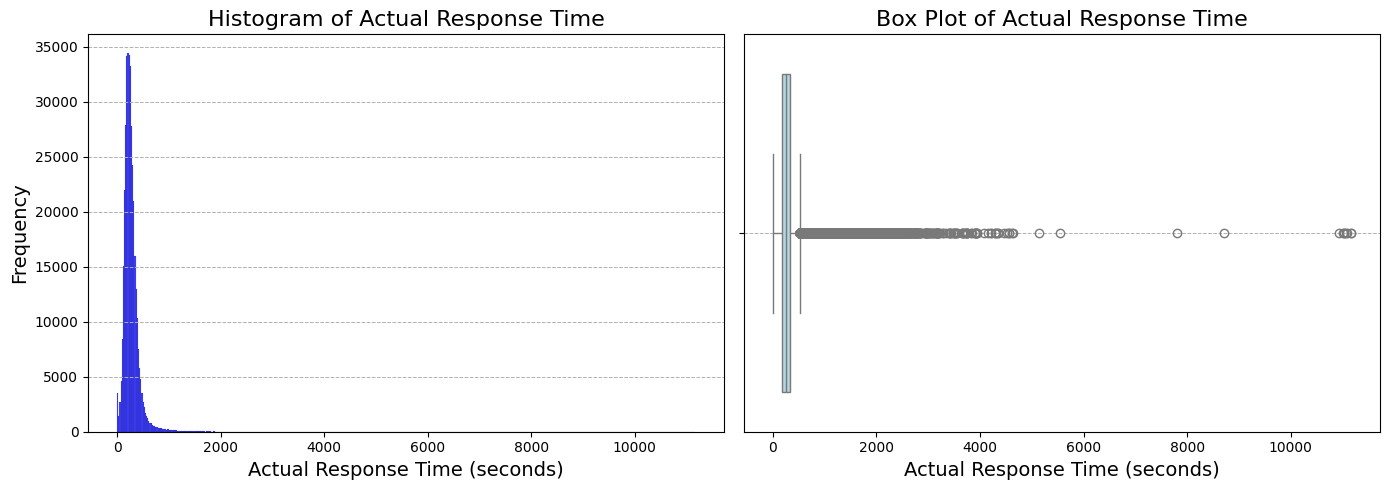

In [18]:
# Create subplots: One row and two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Histogram
sns.histplot(df['actual_response_time'].dropna(), bins=500, kde=False, ax=axes[0], color='blue', edgecolor='black')
axes[0].set_title('Histogram of Actual Response Time', fontsize=16)
axes[0].set_xlabel('Actual Response Time (seconds)', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7)

# Box Plot
sns.boxplot(x=df['actual_response_time'].dropna(), ax=axes[1], color='lightblue')
axes[1].set_title('Box Plot of Actual Response Time', fontsize=16)
axes[1].set_xlabel('Actual Response Time (seconds)', fontsize=14)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

We can also do box plots to compare beat and priority.

- The beat column represents which station's jurisdiction the incident was in, but not necessarily which station ended up responding to the call. There are also two 'other jurisdiction' beats that are incidents that are outside of the Cincinnati Fire Department's jurisdiction. This plot can give us an idea of how the response times vary by area.
- The priority box plot shows us that high priority calls have a slightly lower average response time, and a slightly smaller range of response times.



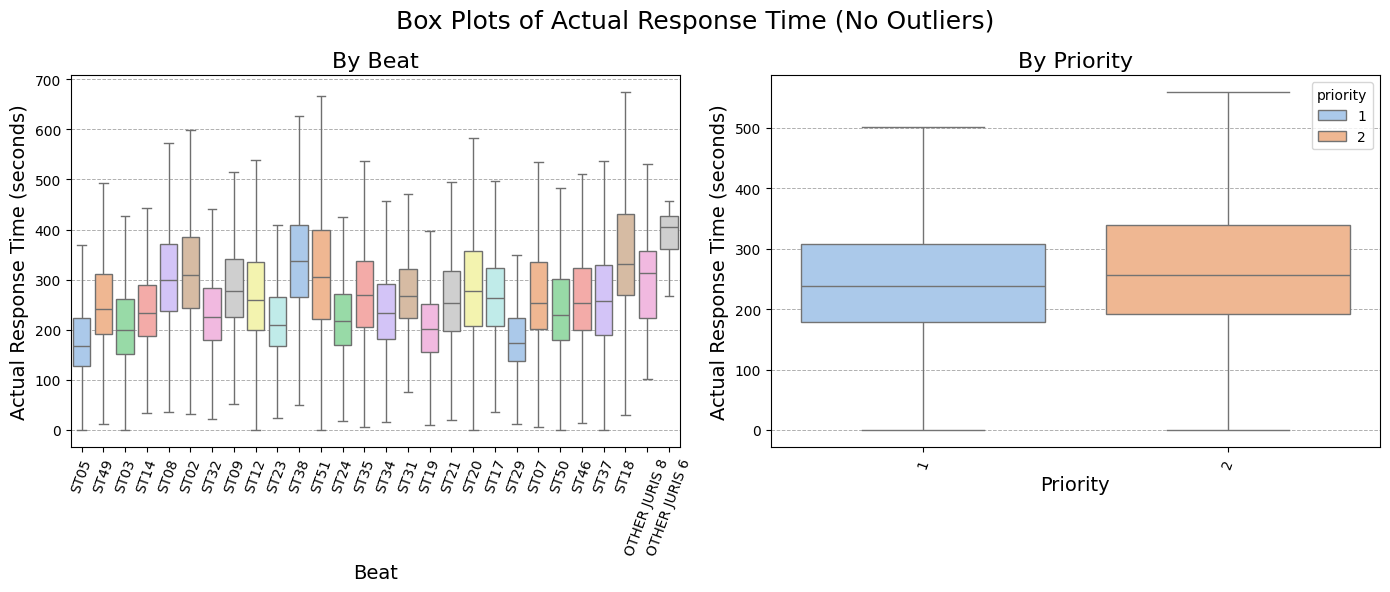

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
fig.suptitle('Box Plots of Actual Response Time (No Outliers)', fontsize=18)

sns.boxplot(data=df.dropna(subset=['actual_response_time', 'beat']),
            ax=axes[0],
            x='beat',
            y='actual_response_time',
            palette='pastel',
            hue='beat',
            showfliers=False)  # Set showfliers to False

axes[0].set_title(f'By Beat', fontsize=16)
axes[0].set_xlabel('Beat', fontsize=14)
axes[0].set_ylabel('Actual Response Time (seconds)', fontsize=14)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=70)

sns.boxplot(data=df.dropna(subset=['actual_response_time', 'priority']),
            ax=axes[1],
            x='priority',
            y='actual_response_time',
            palette='pastel',
            hue='priority',
            showfliers=False)  # Set showfliers to False

axes[1].set_title(f'By Priority', fontsize=16)
axes[1].set_xlabel('Priority', fontsize=14)
axes[1].set_ylabel('Actual Response Time (seconds)', fontsize=14)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=70)

plt.tight_layout()
plt.show()

### Incident Distribution Over Time

Below I make histograms binned by quarter to view the distribution of incidents over time. We can stack them based on shift and priority. 

The general distribution of incidents through each quarter makes sense. Generally, EMS incidents were lower in 2020 due to people staying home more during COVID. In general, incidents have increased over time, especially in the last two years. I am okay with this distribution for my dataset since it seems realistic. The priority levels seem to be distributed in a realistic way, as well.


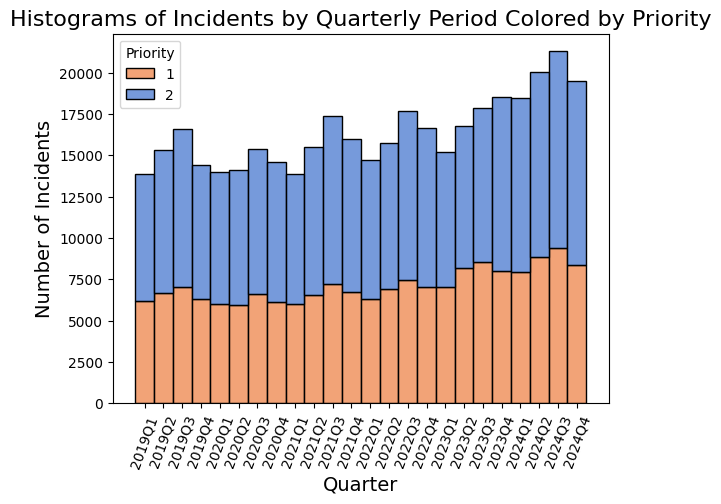

In [20]:
# Create a quarter column for binning
df.loc[:, "quarter"] = df.create_time_incident.dt.to_period('Q').astype(str)

# Count the number of incidents by quarter and shift
counts_priority = df.groupby(['quarter', 'priority']).size().reset_index(name='count_priority')

# Histogram for priority
plt.figsize=(8, 6)
sns.histplot(data=df, stat='count', multiple='stack', x='quarter',  kde=False, palette='muted', hue='priority', element='bars', legend=True)
plt.title('Histograms of Incidents by Quarterly Period Colored by Priority', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.xticks(rotation=70)
plt.legend(title='Priority', labels=['1','2'])

plt.show()

### Heatmap Animated by Month

Below I use Folio to make a HeatMapWithTime grouped by month so that I can an idea of where incidents cluster, and whether the clusters change over time. It looks like we mostly see hot spots that are in fairly consistent locations, but it's possible that there are some trends over time. It might be a good idea to test recency weighting for our samples.


In [0]:
# Make month column
df = df.assign(month=df['create_time_incident'].dt.to_period('M').dt.to_timestamp())

# Initialize the map centered around the mean coordinates
m = folium.Map(
    location=[df['latitude_x'].mean(), df['longitude_x'].mean()],
    zoom_start=12,
    tiles='CartoDB positron',
    attr='© <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors © <a href="https://carto.com/about-carto/">CARTO</a>'
)

# Group data by month
grouped = df.groupby('month')

# Compile the heatmap data
heat_data_time = []
time_index = []

for name, group in grouped:
    heat_points = group[['latitude_x', 'longitude_x']].values.tolist()
    heat_data_time.append(heat_points)
    time_index.append(name.strftime('%b %Y'))

HeatMapWithTime(
    data=heat_data_time,
    index=time_index,
    auto_play=True,
    max_opacity=0.7,
    radius=12,
    blur=1,
).add_to(m)

folium.LayerControl().add_to(m)

display(m)

### EDA Conclusions

To summarize the EDA results: 

- I dropped incidents that were not useful to the dataset.
- I standardized the **incident\_type\_id** column.  
- I created columns for **priority**, and **actual\_response\_time**.
- For the next steps, I will keep the columns: **create\_time\_incident**, **latitude\_x**, **longitude\_x**, **beat**, **priority**, and **actual\_response\_time**.


In [22]:
# Drop columns we don't need for modeling or analysis
df = df.drop(columns=['quarter','month','dispatch_time_primary_unit', 'arrival_time_primary_unit', 'closed_time_incident','incident_type_id','disposition_text','incident_type_desc','address_x','cfd_incident_type','cfd_incident_type_group'])

# Reindex the cleaned data
df = df.reset_index(drop=True)

## Modeling

### Modeling Objectives

The goal of this project is to find good posting locations for ambulance using our prepared incident data. So what makes a good posting location? 

- We want the ambulance to be able to arrive at the scene of an incident as quickly as possible.
- If there are higher priority incidents, we would like to prioritize getting to those locations more quickly, without compromising response time to other locations.
- We want to ensure equitable coverage for the jurisdiction the department is responsible for.
- We want the locations to be safe and convenient for the crews of the ambulance.
- The decisions may need to incorporate financial and political considerations.

This model will focus mainly on objectives related to minimizing response times.

### Model Selection

The ambulance posting location problem is primarily a spatial clustering problem. The goal is to group geographical locations into clusters, and then position ambulances at strategic points within the clusters to minimize response times.

We have several types of options for clustering models:

- **K\-Means**
  - Simple and fast with easily understandable results
  - User sets n\_clusters
  - Assumes spherical and equally sized clusters

- **Density\-Based Spatial Clustering of Applications with Noise \(DBSCAN\)**
  - Allows discovery of clusters with arbitrary shapes
  - Robust to outliers
  - Does not require specifying the number of clusters
  - Sensitive to parameters
  - Struggles with varying densities

- **Agglomerative Hierarchical Clustering**
  - Provides a hierarchy of clusters
  - Allows setting maximum distance, and minimizes maximum distance within clusters
  - Very computationally expensive for large datasets.
  - Results are very dependent on linkage method setting

For this project, I will choose a **K\-Means model**. I want a simple and fast model since I am processing a large amount of data and this is my first attempt at modeling this type of data. I would also like to control the number of clusters produced since in the real\-world, the number of ambulance posting locations would be resource\-limited. I think that the assumption of spherical, equally sized clusters can be mitigated by evaluating and optimizing the model using my ERT metric.

My choices for K\-Means models are:

- **Standard K\-Means**: The standard K\-Means model supports weighting and has an easy to use implementation in scikit\-learn. It minimizes the cluster inertia \(which is the the sum of squared distances between each data point and its assigned cluster centroid\), which is a good approximation for the estimated response time.
- **Bisecting K\-Means**: Bisecting K\-Means splits data into two clusters in repeated steps until reaching the requested number of clusters. This usually produces more similarly\-sized clusters, which could reduce the potential for outliers with very high distances from the centers. This might make Bisecting K\-Means a good choice for our purposes.
- **MiniBatch K\-Means**: This model is very efficient on large datasets, but it is less accurate than standard K\-Means.
- **KCenter modeling**: This method could minimize the maximum distance, but there are no implementations in the machine learning libraries, and all known implementation methods are very slow.
- **K\-Metoids \(PAM/Partitioning Around Medoids\)**: This method uses actual data points as cluster centers instead of means. The interesting thing about this model is that it can work with alternative distance metrics, including a pre\-computed distance matrix. This would allow us to use travel times \(as in our estimated response time metric\) more directly in the K\-Means model, rather than indirectly in the evaluation and optimization process. However, computing the distance matrix could be a complicated process and might be too involved for this project.

Although it has a major limitation in that it can only optimize for euclidean distance, I believe that the standard KMeans model is the best first model to try. I would also like to try Bisecting K\-Means. With both of these models, I can use gp\_minimize with an objective function that minimizes the estimated response time by trying different random states. I can also use the sample\_weight parameter to add a higher weight to high\-priority calls, and to more recent calls. I can create a hyper\-parameter to tune in the optimization parameter that determines the type of function for the recency weight.

### Model Features: Geospatial Data

Since my problem is a geospatial clustering problem, the two main features will be **latitude\_x** and **longitude\_x**. I will need to convert the DataFrame into a GeoDataFrame using these values as the geometry. The CRS type for a GeoDataFrame is the type of coordinate system that the geometry is in. The CRS for longitude and latitude coordinates is "EPSG:4326". \([An overview of coordinate reference systems can be viewed here.](https://docs.qgis.org/3.40/en/docs/gentle_gis_introduction/coordinate_reference_systems.html)\)

Longitude and latitude coordinates are geographical coordinates. In order to use our location data as a feature in a model, we should project the locations into planar coordinates, such as Universal Transverse Mercator \(UTM\). The function ox.projection.project\_gdf automatically determines the correct UTM zone to project the coordinates given the latitude and longitude space. Since Cincinnati exists entirely within UTM Zone 16, the result should be "EPSG:32616".

I will use a naming convention for GeoDataFrames with "EPSG:32616" that appends \_P to the name.



In [23]:
# Convert dataframe into a GeoDataFrame and project to default planar CRS
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude_x,
                                                   df.latitude_x),
                       crs="EPSG:4326")
gdf_P = ox.projection.project_gdf(gdf)
print(f'Projected GDF CRS: {gdf_P.crs}')
gdf_P.info()

Projected GDF CRS: EPSG:32616
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 393400 entries, 0 to 393399
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   create_time_incident  393400 non-null  datetime64[ns]
 1   latitude_x            393400 non-null  float64       
 2   longitude_x           393400 non-null  float64       
 3   beat                  393373 non-null  object        
 4   priority              393400 non-null  int64         
 5   actual_response_time  375840 non-null  Int32         
 6   geometry              393400 non-null  geometry      
dtypes: Int32(1), datetime64[ns](1), float64(2), geometry(1), int64(1), object(1)
memory usage: 19.9+ MB


### Sample Weighting

With KMeans, we can apply weights to the samples. We can use the priority column to weight high priority incidents more than low priority incidents in our model, under the theory that they are more predictive of call location. We can also try giving a higher weight to more recent data, under the hypothesis that incidents have some time\-based trends.

#### Recency Weight Function

Exponential decay functions are generally a good choice for recency weighting. We can introduce a lambda value that determines the rate of decay. 
$$\Large
\text{weight} = e^{-\lambda\times t}$$
If we train the model on older data, and evaluate and optimize on the newest data, we will be able to account for time\-based trends in the data. We should optimize over log\(lambda\) and transform it to the lambda value \(lambda^10\) in order to make the optimization space more efficient. We should also normalize the timestamp and scale to values between 0 and 10.


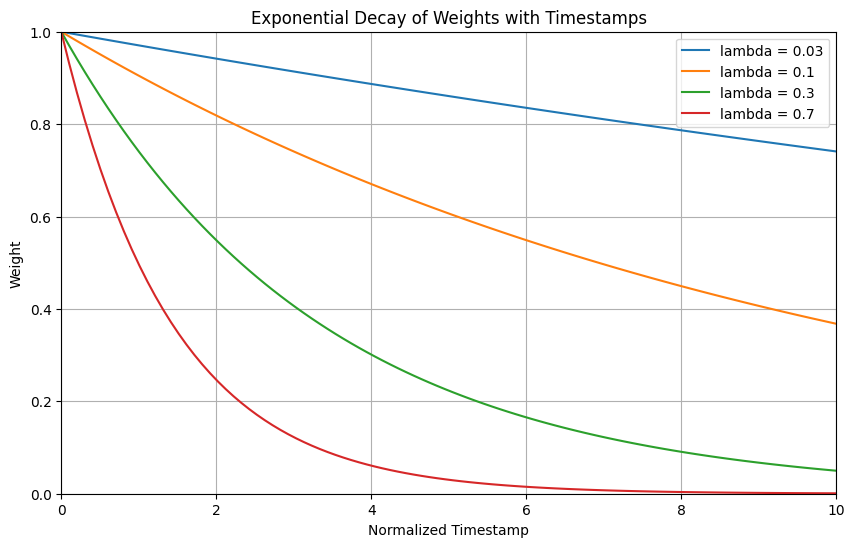

In [24]:
# This cell demonstrates the effect of various lambda values on 
# the exponential decay function for recency weight

# Generate example timestamps (0 to 10, simulating times since an event)
timestamps = np.linspace(0, 10, 100)

# Calculate weights for different lambdas
lambdas = [0.03, 0.1, 0.3, 0.7]  # Different decay rates
weights = {l: np.exp(-l * timestamps) for l in lambdas}

# Plot the results
plt.figure(figsize=(10, 6))

for l, w in weights.items():
    plt.plot(timestamps, w, label=f'lambda = {l}')

plt.title('Exponential Decay of Weights with Timestamps')
plt.xlabel('Normalized Timestamp')
plt.ylabel('Weight')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid(True)
plt.show()

### Defining a Response Time Metric

Using "actual response time" as a metric has a few problems. First of all, it is noisy. The location of the post is a partial factor in the actual response time. Other factors could include traffic, weather, data entry errors, crew navigational issues, other human factors. To add to this, in our data we can only guess that the ambulance was posted at the closest fire station to the incident, but we do not actually know where the ambulance was during dispatch time. The other problem for us is that we do not have an actual response time for each hypothetical location where each post could be.

In order to evaluate our model we should create a new metric that does not incorporate noise and can be measured for any of the hypothetical posting locations. One good strategy would be to try to estimate the driving time to the incident location from the nearest posting location. Since we know where the current fire stations are located, we can also get a less noisy metric to evaluate the current "baseline" posting locations. An estimated response time \(ERT\) metric is a better metric to use for the purpose of optimizing posting locations than actual response time, because it is solely dependent on the physical locations of the posts, and not things like weather, traffic, and human factors, which we are not trying to incorporate.

To create an estimated response time metric, we can use the osmnx library to create a graph within the bounds of Cincinnati. The library has many features and functions that allow us to predict driving times between nodes in the graph. Because we have a lot of data, it is a good idea to create a class that holds the graph and also uses a cache to store any node\-to\-node path length look\-ups that we perform on the graph, so that we only have to do them once each. We use travel time as the path length weight, which will result in an estimated response time in seconds. 

We should keep in mind a few caveats to this metric:

- It only represents the portion of the response time directly related to the driving distances and speeds on the map, and doesn't consider traffic or any other factors.
- We must convert real locations to their nearest nodes on the graph, so locations that are very close will have an ERT of 0.
- Some nodes in the graph are not connected because edges of "drive\_service" type are included in the graph. These would be cases where the ambulance may have to drive off\-road to a location, or the crews may have to travel on foot. In these cases, we will return a travel time that is approximated by the euclidean distance multiplied by the average travel\_time of edges in the graph. There are probably more accurate ways to handle this, but since the situation is fairly rare, I think this is good enough for our purposes.



In [25]:
# Create the PathCacheGraph class
class PathCacheGraph:
    def __init__(self, graph_filepath, graph_bounds, hwy_speeds, path_length_weight='travel_time', n_jobs=-1):
        self.graph_filepath = graph_filepath
        self.graph_bounds = graph_bounds
        self.hwy_speeds = hwy_speeds
        self.path_length_weight = path_length_weight
        self.path_length_cache = {}
        self.n_jobs = n_jobs if n_jobs > 0 else mp.cpu_count()
        
        self._load_graph()
        self._get_avg_edge_weight()
        
    def _load_graph(self):
        if Path(self.graph_filepath).exists():
            print("Loading cached graphml")
            graph = ox.io.load_graphml(self.graph_filepath)
        else:
            print("Caching graphml")
            graph = ox.graph.graph_from_bbox(self.graph_bounds,network_type="drive_service")
            graph = ox.routing.add_edge_speeds(graph, hwy_speeds=self.hwy_speeds)
            graph = ox.routing.add_edge_travel_times(graph)
            ox.io.save_graphml(graph, self.graph_filepath)

        self.graph = ox.projection.project_graph(graph)
    
    def _get_avg_edge_weight(self):
        weighted_distances = []
        for u,v,data in self.graph.edges(data=True):
            if self.path_length_weight in data:
                weight = data[self.path_length_weight]
                source_pos = self.graph.nodes[u].get('x'), self.graph.nodes[u].get('y')
                target_pos = self.graph.nodes[v].get('x'), self.graph.nodes[v].get('y')
                distance = np.linalg.norm(np.array(source_pos) - np.array(target_pos))
                if distance > 0:
                    weighted_distances.append(weight/distance)
        if not weighted_distances:
            self.avg_edge_weight = None
        else:
            self.avg_edge_weight = np.mean(weighted_distances)
        return
    
    def _compute_shortest_path_batch(self, pairs):
        results = []
        for source_node, target_node in pairs:
            if source_node == target_node:
                results.append(((source_node, target_node), 0))
                continue
            try:
                path_length = nx.shortest_path_length(self.graph,
                                                      source=source_node,
                                                      target=target_node,
                                                      weight=self.path_length_weight)
                results.append(((source_node, target_node), path_length))
            except Exception as e:
                # There is no path on the network between these nodes
                # Approximate distance geospacially
                source_pos = self.graph.nodes[source_node].get('x'), self.graph.nodes[source_node].get('y')
                target_pos = self.graph.nodes[target_node].get('x'), self.graph.nodes[target_node].get('y')
                distance = np.linalg.norm(np.array(source_pos) - np.array(target_pos))
                est_path_length = distance * self.avg_edge_weight
                source_target_gdf = gpd.GeoDataFrame(geometry=[Point(source_pos),Point(target_pos)], crs="EPSG:32616").to_crs('EPSG:4326')
                results.append(((source_node, target_node), est_path_length))
        return results
                
    def _chunk_pairs(self, pairs):
        n = self.n_jobs
        chunk_size = max(1, len(pairs) // n)
        chunks = [
            pairs[i:i + chunk_size] for i in range(0, len(pairs), chunk_size)
        ]
        if len(chunks) < n:
            chunks += [[] for _ in range(n - len(chunks))]
        elif len(chunks) > n:
            excess = chunks[n:]
            chunks = chunks[:n]
            for chunk in excess:
                chunks[-1].extend(chunk)
        return chunks
        
    def estimate_response_times(self, source_coords, target_coords):
        if len(source_coords) != len(target_coords):
            raise ValueError(
                "The number of source coordinates and target coordinates must be the same for one-to-one correspondence."
            )
        source_nodes = ox.distance.nearest_nodes(self.graph, source_coords.x, source_coords.y)
        target_nodes = ox.distance.nearest_nodes(self.graph, target_coords.x, source_coords.y)
        
        pairs = list(zip(source_nodes, target_nodes))
        unique_pairs = set(pairs)
        
        uncached_pairs = [
            pair for pair in unique_pairs if pair not in self.path_length_cache
        ]
        
        if uncached_pairs:
            chunks = self._chunk_pairs(uncached_pairs)

            results = Parallel(n_jobs=self.n_jobs, backend='loky')(
                delayed(self._compute_shortest_path_batch)(chunk)
                for chunk in chunks)

            for chunk_result in results:
                for pair, path_length in chunk_result:
                    self.path_length_cache[pair] = path_length

        travel_times = [
            self.path_length_cache.get(pair, np.nan) for pair in pairs
        ]

        return travel_times

In [26]:
# Make a graph of Cincinnati with path length cache
graph_filepath = "./data/cincinnati.graphml" # If we have already created the graphml, we can load the file we saved.
graph_bounds = (-84.72310504288677, 39.03215211164518, -84.30866353558929, 39.23149458211676)
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}

cincinnati_graph = PathCacheGraph(graph_filepath, graph_bounds, hwy_speeds, path_length_weight='travel_time', n_jobs=10)

Loading cached graphml


### AmbulancePostOptimizer Class

The AmbulancePostOptimizer Class will handle:

- Splitting and storing the data
- Calculating and storing the baseline ERTs
- Creating sample weights by combining priority weights and recency weights
- Using gp\_minimize and an objective function to optimize the K\-Means model, either standard or bisecting
- Training a final model on the entire dataset based on the best parameters from the optimization
- Calculating the ERTs for the final model

#### Objective Function

The objective function will minimizes the average estimated response time \(ERT\) of the test data, normalized by the average baseline ERT of the test data.
$$\Large
\text{Objective} = \min \left(\sum_{i=1}^{n} ERT_i\right)
$$n is the number of samples in the test data.

The objective function could be altered to produce models with different outcomes. For example, we could incorporate a maximum ERT constraint or a weighted sum that attempts to minimize other factors, such as n\_clusters. For the purposes of this project, I am going to keep the objective simple by only minimizing the average ERT, and constrain the n\_clusters variable to equal the number of baseline posting locations by fixing the parameter.



In [27]:
class AmbulancePostOptimizer:

    def __init__(self, data, train_indices, test_indices, graph):
        self.data = data
        self.graph = graph

        self.split_data(train_indices, test_indices)
        self.last_optimized_model_type = ""

    def split_data(self, train_indices, test_indices):
        
        self.train_data = self.data.iloc[train_indices]
        self.test_data = self.data.iloc[test_indices]
        self.scaler = StandardScaler()
        train_points = np.stack(
            (self.train_data.geometry.x, self.train_data.geometry.y), axis=-1)
        self.train_X = self.scaler.fit_transform(train_points)
        test_points = np.stack(
            (self.test_data.geometry.x, self.test_data.geometry.y), axis=-1)
        self.test_X = self.scaler.transform(test_points)
        return

    def calculate_baselines(self, baseline_stations):
        self.baseline_stations = baseline_stations
        self.baseline_gdf_P = self._get_closest_stations(self.data)
        self.baseline_gdf_P['ert'] = self._estimate_response_times(self.baseline_gdf_P, self.data)
        self.baseline_n_clusters = len(self.baseline_stations)
        return

    def optimize(self, space, model_type, n_calls=20, random_state=42):
        
        if model_type == 'standard':
            objective_function = self._objective_std
        elif model_type == 'bisecting':
            objective_function = self._objective_bisect
        else:
            raise ValueError(f"The model_type parameter {model_type} is not valid.")

        self.last_optimized_model_type = model_type

        with warnings.catch_warnings(), tqdm(total=n_calls, desc="Optimization Progress") as pbar:
            warnings.filterwarnings("ignore", category=UserWarning, module="skopt")
            def callback(res):
                pbar.update(1)
           

            optimization_result = gp_minimize(objective_function,
                                              space,
                                              acq_func='EI',
                                              n_calls=n_calls,
                                              random_state=random_state,
                                              callback=[callback],
                                              n_jobs=1)

        self.best_params = dict(zip([dim.name for dim in space], optimization_result.x))
        return optimization_result

    def train_final_model(self):
        if self.best_params is None:
            raise ValueError(
                "No best parameters found. Please run optimize() first.")
            
        random_state = self.best_params['random_state']
        log_lmb = self.best_params['log_lmb']
        lmb = 10 ** log_lmb
        
        data_points = np.stack((self.data.geometry.x, self.data.geometry.y),
                               axis=-1)
        self.data_X = self.scaler.transform(data_points)

        sample_weights = self._get_sample_weights(self.data, lmb)
        
        if self.last_optimized_model_type == 'standard':
            self.final_model = KMeans(n_clusters=self.baseline_n_clusters,
                                            random_state=random_state,
                                            init='k-means++',
                                            n_init=5,
                                            max_iter=500,
                                            tol=1e-6
                                          ).fit(
                                               self.data_X,
                                               sample_weight=sample_weights)
        elif self.last_optimized_model_type == 'bisecting':
            self.final_model = BisectingKMeans(n_clusters=self.baseline_n_clusters,
                                            random_state=random_state,
                                            init='k-means++',
                                            n_init=5,
                                            max_iter=500,
                                            tol=1e-6
                                          ).fit(
                                               self.data_X,
                                               sample_weight=sample_weights)
        else:
            raise ValueError(f"The self.last_optimized_model_type parameter {self.last_optimized_model_type} is not valid.")
            
        self.final_post_locations = self.scaler.inverse_transform(
            self.final_model.cluster_centers_)
        self.final_post_labels = self.final_model.labels_

        print("Final model trained with best parameters.")
        return

    def evaluate_final_model(self):
        if self.final_model is None:
            raise ValueError(
                "No final model found. Please run train_final_model() first.")
        
        pred_posts = gpd.GeoDataFrame(
            {
                'post':
                self.final_post_labels,
                'geometry': [
                    Point(self.final_post_locations[cluster])
                    for cluster in self.final_post_labels
                ]
            },
            crs=self.test_data.crs)

        return self._estimate_response_times(pred_posts, self.data)

    def _get_closest_stations(self, incidents):
        stations = gpd.GeoDataFrame(
            geometry=[Point(lon, lat) for lon, lat in self.baseline_stations],
            crs="EPSG:4326")
        stations = ox.projection.project_gdf(stations)

        closest_stations = gpd.sjoin_nearest(incidents,
                                             stations,
                                             how='left',
                                             lsuffix='incident',
                                             rsuffix='station',
                                             distance_col="distance")
        geometry_mapping = stations.geometry.to_dict()
        geometry = closest_stations['index_station'].apply(
            lambda i: geometry_mapping.get(i) if pd.notna(i) else pd.NA)

        return gpd.GeoDataFrame(
            {
                'post': closest_stations.index_station,
                'geometry': geometry
            },
            crs=stations.crs)

    def _estimate_response_times(self, posts, incidents):
        travel_times = self.graph.estimate_response_times(posts.geometry, incidents.geometry)
        return pd.Series(travel_times,
                         index=incidents.index,
                         dtype=pd.Float64Dtype()).astype('Int32')

        
    def _get_sample_weights(self, data, lmb):
        scaler = MinMaxScaler(feature_range=(0, 10))
        time_norm = 10 - scaler.fit_transform(data[['create_time_incident']])
        recency_weights = np.exp(-lmb * time_norm).flatten()
        priority_weights = np.where(data['priority'] == 1, 1, 0.75)
        return ( 0.5 * recency_weights) + ( 0.5 * priority_weights)


    def _calculate_objective(self, model):
        cluster_centers = self.scaler.inverse_transform(model.cluster_centers_)
        cluster_labels = model.predict(self.test_X)

        pred_posts = gpd.GeoDataFrame(
            {
                'post':
                cluster_labels,
                'geometry': [
                    Point(cluster_centers[cluster])
                    for cluster in cluster_labels
                ]
            },
            crs=self.test_data.crs)

        pred_erts = self._estimate_response_times(pred_posts, self.test_data)
        return pred_erts.mean()
        
    
    def _objective_std(self, params):
        random_state, log_lmb = params
        lmb = 10 ** log_lmb

        train_weight = self._get_sample_weights(self.train_data, lmb)

        model = KMeans(n_clusters=self.baseline_n_clusters,
                                random_state=random_state,
                                init='k-means++',
                                n_init=5,
                                max_iter=500,
                                tol=1e-6
                               ).fit(self.train_X, sample_weight=train_weight)

        return self._calculate_objective(model)
        
    
    def _objective_bisect(self, params):
        random_state, log_lmb = params
        lmb = 10 ** log_lmb

        train_weight = self._get_sample_weights(self.train_data, lmb)

        model = BisectingKMeans(n_clusters=self.baseline_n_clusters,
                                random_state=random_state,
                                init='k-means++',
                                n_init=5,
                                max_iter=500,
                                tol=1e-6
                               ).fit(self.train_X, sample_weight=train_weight)

        return self._calculate_objective(model)

### Train/Test Split

Normally unsupervised learning models do not have data leakage because labels are not incorporated into the model. However, data leakage can be incorporated when the model is being optimized. In this case, we are incorporating a recency bias into the model and we want the evaluation to tell us whether adding weight to more recent data is helpful for minimizing the objective function of "future data". Since we have 5 full years of data, we can train the model on the first 4 years, and then evaluate and optimize on the last year, simulating a field test.



In [28]:
# Get indices for the train/test split
last_year = gdf_P['create_time_incident'].max().year
train_indices = gdf_P[gdf_P['create_time_incident'].dt.year < last_year].index.tolist()
test_indices = gdf_P[gdf_P['create_time_incident'].dt.year == last_year].index.tolist()
print(f'Train size = {len(train_indices)}, Test size = {len(test_indices)}')
print(f'Test size is {len(test_indices)/(gdf_P.shape[0]) * 100:.2f}% of total data')

Train size = 314127, Test size = 79273
Test size is 20.15% of total data


In [29]:
# Initialize optimizer
optimizer = AmbulancePostOptimizer(gdf_P, train_indices, test_indices, cincinnati_graph)

## Get Baseline Metrics

Now that we've created and initialized our optimizer, we can evaluate the baseline posting locations with our ERT metric. The posting locations were obtained from a [custom Google map](https://www.google.com/maps/d/u/0/viewer?hl=en&gl=us&ie=UTF8&oe=UTF8&msa=0&dg=feature&mid=1btH0gUTUGLzzYK8fOfsFzeSxOR4&ll=39.13977823260078%2C-84.54026450000002&z=12) provided on the City of [Cincinnati's website](https://www.cincinnati-oh.gov/fire/about-fire/cfd-fire-districts/). We can get some baseline ERT statistics on the test data and the full data.


In [30]:
# Get baselines from firestations
baseline_stations = [[-84.479197,39.194191],[-84.507767,39.106352],[-84.516716,39.116626],[-84.389537,39.092288],[-84.434465,39.17957],[-84.472141,39.163941],[-84.540839,39.136146],[-84.519328,39.099608],[-84.551053,39.105116],[-84.424563,39.107289],[-84.509304,39.132226],[-84.542732,39.160472],[-84.543945,39.099608],[-84.475916,39.129605],[-84.590005,39.113604],[-84.527196,39.113604],[-84.4253,39.1544],[-84.492719,39.145709],[-84.519225,39.143468],[-84.58223,39.139917],[-84.584826,39.08256],[-84.517536,39.169772],[-84.442116,39.139458],[-84.393178,39.159715],[-84.690992,39.112254],[-84.546103,39.19695]]

# Calculate baselines and add to gdf_P
optimizer.calculate_baselines(baseline_stations)
gdf_P['baseline_ert'] = optimizer.baseline_gdf_P['ert']
gdf_P['baseline_post'] = optimizer.baseline_gdf_P['post']

# Make a gdf for the baseline posts reprojected to lat/long for mapping
baseline_posts_gdf = optimizer.baseline_gdf_P[['post','geometry']].drop_duplicates().sort_values(by='post').reset_index(drop=True).to_crs(epsg=4326)

print("====== Baseline Statistics on Test Data ======")
print(gdf_P.loc[test_indices]['baseline_ert'].describe())
print("====== Baseline Statistics on Full Data ======")
print(gdf_P['baseline_ert'].describe())

====== Baseline Statistics on Test Data ======
count       79273.0
mean       91.72712
std      103.862923
min             0.0
25%            34.0
50%            75.0
75%           129.0
max          2091.0
Name: baseline_ert, dtype: Float64
====== Baseline Statistics on Full Data ======
count      393400.0
mean      93.203266
std      101.436547
min             0.0
25%            34.0
50%            76.0
75%           132.0
max          2091.0
Name: baseline_ert, dtype: Float64


### Evaluating ERT as a Metric

Since we are introducing ERT as our metric and assuming it is related to the actual response time, let's look into how valid that assumption is. Here, we get the Pearson correlation, which captures linear correlation, and the Spearman correlation, which captures monotonic correlations. \(We will consider a random sample of the dataset in order to limit the effect of sample size on the p\-value.\)

The Pearson Correlation of ~0.152 with a p\-value 3.92e\-27 tells us that there is a weak positive linear correlation between the actual response time and ERT metric, and that the correlation is highly statistically significant. The Spearman correlation of ~0.38 with p\-value of 2.76e^\-172 tells us that there is a moderate\-to\-weak monotonic relationship that is extremely statistically significant. 

Charting the ERT against actual response time, we can see that more of the less correlated points represent a greater actual response time value than ERT.  This is as expected, as many of the flaws introducing noise into the actual response time are delays, for traffic, crew readiness to immediately respond, weather, etc.

Considering the noise involved in the "actual response time" metric, where many other factors besides posting location are involved in actual response times, as well as the flaws in our actual response time metric \(we can't know with certainty where the ambulance actually was, there could be data entry errors, etc.\), finding this level of correlation with high statistical significance gives me confidence that my ERT metric is a good evaluation and optimization metric for this problem.



Pearson Correlation: 0.15172160821983682, p-value: 3.9153799176811286e-27
Spearman Correlation: 0.380803550569392, p-value: 2.7556841876059984e-172


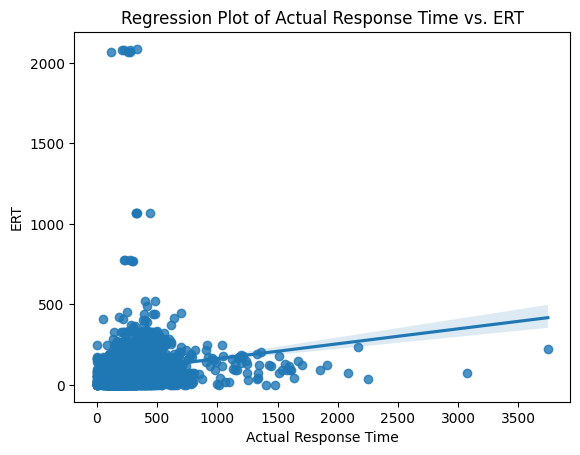

In [31]:
baseline_ert_actual_sampled = gdf_P[['actual_response_time','baseline_ert']].dropna().sample(5000, random_state=42)

corr_pearson, p_value_pearson = pearsonr(baseline_ert_actual_sampled['actual_response_time'], baseline_ert_actual_sampled['baseline_ert'])
print(f'Pearson Correlation: {corr_pearson}, p-value: {p_value_pearson}')
corr_spearman, p_value_spearman = spearmanr(baseline_ert_actual_sampled['actual_response_time'], baseline_ert_actual_sampled['baseline_ert'])
print(f'Spearman Correlation: {corr_spearman}, p-value: {p_value_spearman}')

sns.regplot(x='actual_response_time', y='baseline_ert', data=baseline_ert_actual_sampled)
plt.title('Regression Plot of Actual Response Time vs. ERT')
plt.xlabel('Actual Response Time')
plt.ylabel('ERT')
plt.show()

### Standard KMeans Model Optimization

Now, we will optimize using the standard KMeans model over a parameter space that includes random\_state values to encourage the production of varied models, and log\_lmb, which is the log of our lambda value for recency weight, which gets transformed before being used in the exponential decay function to get a recency weight. Recall that optimizing over the log of lambda will create a more balanced search space.

We'll train, evaluate, and store all of the results from the final model so we can reuse the class to optimize on the Bisecting KMeans model with the same data.


In [32]:
# Optimize over space
space = [
    Integer(0, 200, name='random_state'),
    Real(-1.5, -0.15, name='log_lmb'),
]

# Optimize the standard KMean model over the space
print('Optimizing standard KMeans model...')
std_opt_results = optimizer.optimize(space=space, model_type='standard', n_calls=20)
print('Done optimizing!')

# Get best params and best score
std_best_params = optimizer.best_params
std_best_score = std_opt_results.fun
print(f'Best params: {std_best_params}')
print(f'Best score: {std_best_score}')

# Train the model and calculate ERTs
print('Training final model...')
optimizer.train_final_model()
std_model = optimizer.final_model
gdf_P['std_kmeans_post'] = optimizer.final_post_labels
print('Calculating final model ERTS...')
gdf_P['std_kmeans_ert'] = optimizer.evaluate_final_model()

# Make standard KMeans posts gdf reprojected to lat/long for mapping
std_posts_gdf = gpd.GeoDataFrame({
    'post' : range(0, len(optimizer.final_post_locations)),
    'geometry': [Point(x,y) for x, y in optimizer.final_post_locations]
}, crs=gdf_P.crs).to_crs(epsg=4326)

Optimizing standard KMeans model...


Optimization Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Optimization Progress:   5%|▌         | 1/20 [00:19<06:09, 19.47s/it]

Optimization Progress:  10%|█         | 2/20 [00:38<05:46, 19.25s/it]

Optimization Progress:  15%|█▌        | 3/20 [00:57<05:27, 19.29s/it]

Optimization Progress:  20%|██        | 4/20 [01:17<05:07, 19.23s/it]

Optimization Progress:  25%|██▌       | 5/20 [01:36<04:48, 19.25s/it]

Optimization Progress:  30%|███       | 6/20 [01:55<04:29, 19.28s/it]

Optimization Progress:  35%|███▌      | 7/20 [02:15<04:13, 19.48s/it]

Optimization Progress:  40%|████      | 8/20 [02:34<03:53, 19.42s/it]

Optimization Progress:  45%|████▌     | 9/20 [02:54<03:33, 19.45s/it]

Optimization Progress:  50%|█████     | 10/20 [03:13<03:14, 19.42s/it]

Optimization Progress:  55%|█████▌    | 11/20 [03:33<02:54, 19.42s/it]

Optimization Progress:  60%|██████    | 12/20 [03:52<02:35, 19.38s/it]

Optimization Progress:  65%|██████▌   | 13/20 [04:11<02:16, 19.43s/it]

Optimization Progress:  70%|███████   | 14/20 [04:31<01:56, 19.39s/it]

Optimization Progress:  75%|███████▌  | 15/20 [04:50<01:37, 19.43s/it]

Optimization Progress:  80%|████████  | 16/20 [05:10<01:17, 19.45s/it]

Optimization Progress:  85%|████████▌ | 17/20 [05:29<00:58, 19.46s/it]

Optimization Progress:  90%|█████████ | 18/20 [05:49<00:39, 19.63s/it]

Optimization Progress:  95%|█████████▌| 19/20 [06:09<00:19, 19.60s/it]

Optimization Progress: 100%|██████████| 20/20 [06:28<00:00, 19.59s/it]

Optimization Progress: 100%|██████████| 20/20 [06:28<00:00, 19.45s/it]

Done optimizing!
Best params: {'random_state': np.int64(92), 'log_lmb': -1.0494933749623203}
Best score: 86.22148777011088
Training final model...


Final model trained with best parameters.
Calculating final model ERTS...


### Bisecting KMeans Model Optimization

Now we'll optimize over the same space using the Bisecting KMeans model.



In [33]:
# Optimize the bisecting KMean model over the space
print('Optimizing bisecting KMeans model...')
bisect_opt_results = optimizer.optimize(space=space, model_type='bisecting', n_calls=20)
print('Done optimizing!')

# Get best params and best score
bisect_best_params = optimizer.best_params
bisect_best_score = bisect_opt_results.fun
print(f'Best params: {bisect_best_params}')
print(f'Best score: {bisect_best_score}')

# Train the model and calculate ERTs
print('Training final model...')
optimizer.train_final_model()
bisect_model = optimizer.final_model
gdf_P['bisect_kmeans_post'] = optimizer.final_post_labels
print('Calculating final model ERTS...')
gdf_P['bisect_kmeans_ert'] = optimizer.evaluate_final_model()

# Make bisecting KMeans posts gdf reprojected to lat/long for mapping
bisect_posts_gdf = gpd.GeoDataFrame({
    'post' : range(0, len(optimizer.final_post_locations)),
    'geometry': [Point(x,y) for x, y in optimizer.final_post_locations]
}, crs=gdf_P.crs).to_crs(epsg=4326)

# Reproject final gdf into lat/long for mapping
results_gdf = gdf_P.to_crs(epsg=4326)

Optimizing bisecting KMeans model...


Optimization Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Optimization Progress:   5%|▌         | 1/20 [00:28<09:04, 28.68s/it]

Optimization Progress:  10%|█         | 2/20 [00:56<08:29, 28.30s/it]

Optimization Progress:  15%|█▌        | 3/20 [01:24<07:58, 28.16s/it]

Optimization Progress:  20%|██        | 4/20 [01:52<07:26, 27.92s/it]

Optimization Progress:  25%|██▌       | 5/20 [02:20<06:58, 27.91s/it]

Optimization Progress:  30%|███       | 6/20 [02:48<06:31, 27.97s/it]

Optimization Progress:  35%|███▌      | 7/20 [03:16<06:04, 28.05s/it]

Optimization Progress:  40%|████      | 8/20 [03:44<05:35, 27.96s/it]

Optimization Progress:  45%|████▌     | 9/20 [04:12<05:07, 27.94s/it]

Optimization Progress:  50%|█████     | 10/20 [04:40<04:40, 28.00s/it]

Optimization Progress:  55%|█████▌    | 11/20 [05:08<04:12, 28.10s/it]

Optimization Progress:  60%|██████    | 12/20 [05:36<03:43, 27.99s/it]

Optimization Progress:  65%|██████▌   | 13/20 [06:04<03:15, 27.98s/it]

Optimization Progress:  70%|███████   | 14/20 [06:15<02:16, 22.78s/it]

Optimization Progress:  75%|███████▌  | 15/20 [06:25<01:35, 19.06s/it]

Optimization Progress:  80%|████████  | 16/20 [06:53<01:27, 21.80s/it]

Optimization Progress:  85%|████████▌ | 17/20 [07:21<01:11, 23.69s/it]

Optimization Progress:  90%|█████████ | 18/20 [07:32<00:39, 19.87s/it]

Optimization Progress:  95%|█████████▌| 19/20 [08:00<00:22, 22.21s/it]

Optimization Progress: 100%|██████████| 20/20 [08:28<00:00, 23.86s/it]

Optimization Progress: 100%|██████████| 20/20 [08:28<00:00, 25.40s/it]

Done optimizing!
Best params: {'random_state': np.int64(98), 'log_lmb': -1.3999213358067328}
Best score: 102.9650070011227
Training final model...


Final model trained with best parameters.
Calculating final model ERTS...


### Lambda Value

Let's take a look at the exponential decay rates for the best version of the standard and bisecting kmeans models. It looks like both sets of optimization results chose a moderate decay rate. The standard KMeans decay rate reduced the weight of older incidents more than bisecting KMeans. This difference likely arises because standard KMeans is more sensitive to the overall distribution of data points, including the weighting. The bisecting KMeans model algorithm is more localized, starting with a single cluster and recursively splitting the largest into two. It is potentially less sensitive to global shifts in data distribution over time, and a lower decay rate could be sufficient for capturing time\-based trends relavent to each individual split. It doesn't need to downweight older data as drastically because it's not trying to optimize for the entire dataset's structure in each step, but for the structure within the currently bisected cluster.


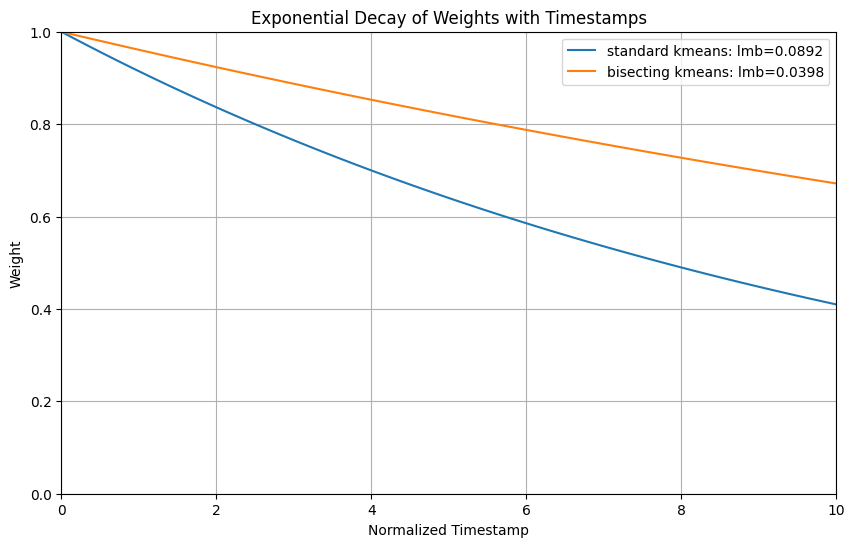

In [34]:
# Graph the lambda values for both models
std_lmb = 10**std_best_params['log_lmb']
bisect_lmb = 10**bisect_best_params['log_lmb']

timestamps = np.linspace(0, 10, 100)

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(timestamps, np.exp(-std_lmb * timestamps), label=f'standard kmeans: lmb={std_lmb:.4f}')
plt.plot(timestamps, np.exp(-bisect_lmb * timestamps), label=f'bisecting kmeans: lmb={bisect_lmb:.4f}')

plt.title('Exponential Decay of Weights with Timestamps')
plt.xlabel('Normalized Timestamp')
plt.ylabel('Weight')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

### Model Statistics Comparison

Now we can compare the ERT statistics between the baseline and the optimized KMeans model for the test set and the full dataset. The standard KMeans model improved slightly on the mean ERT, and improved the standard deviation over the baseline posting locations in both the test and full dataset. It did not improve the maximum ERT in the test dataset, but it did improve in the full dataset. The bisecting KMeans model did not improve the mean or standard deviation. It improved the maximum ERT in the test dataset.



In [35]:
print(f'=========== Statistics on Test Data ===========')
baseline_test_stats = results_gdf.loc[test_indices]['baseline_ert'].describe()
std_test_stats = results_gdf.loc[test_indices]['std_kmeans_ert'].describe()
bisect_test_stats = results_gdf.loc[test_indices]['bisect_kmeans_ert'].describe()
print(pd.concat([baseline_test_stats, std_test_stats, bisect_test_stats],
                 keys=['baseline', 'standard', 'bisecting'],
                 axis=1))

print(f'=========== Statistics on Full Data ===========')
baseline_full_stats = results_gdf['baseline_ert'].describe()
std_full_stats = results_gdf['std_kmeans_ert'].describe()
bisect_full_stats = results_gdf['bisect_kmeans_ert'].describe()
print(pd.concat([baseline_full_stats, std_full_stats, bisect_full_stats],
                 keys=['baseline', 'standard', 'bisecting'],
                 axis=1))

=========== Statistics on Test Data ===========
         baseline   standard   bisecting
count     79273.0    79273.0     79273.0
mean     91.72712  88.790458  104.761722
std    103.862923  93.627526  111.355855
min           0.0        0.0         0.0
25%          34.0       42.0        49.0
50%          75.0       77.0        89.0
75%         129.0      117.0       138.0
max        2091.0     2096.0      2095.0
=========== Statistics on Full Data ===========
         baseline   standard   bisecting
count    393400.0   393400.0    393400.0
mean    93.203266  88.458104   105.55698
std    101.436547  91.352022  108.091471
min           0.0        0.0         0.0
25%          34.0       41.0        50.0
50%          76.0       77.0        89.0
75%         132.0      116.0       139.0
max        2091.0     2110.0      2109.0


In [36]:
drop_rows = ['count','min']
percent_change_df = pd.DataFrame()
percent_change_df['% change std kmeans'] = round(((std_full_stats.drop(drop_rows) - baseline_full_stats.drop(drop_rows)) / baseline_full_stats.drop(drop_rows)) * 100, 2)
percent_change_df['% change bisect kmeans'] = round(((bisect_full_stats.drop(drop_rows) - baseline_full_stats.drop(drop_rows)) / baseline_full_stats.drop(drop_rows)) * 100, 2)
print("Percent change statistics over baseline for standard and bisecting kmeans models:")
print(percent_change_df)

Percent change statistics over baseline for standard and bisecting kmeans models:
      % change std kmeans  % change bisect kmeans
mean                -5.09                   13.25
std                 -9.94                    6.56
25%                 20.59                   47.06
50%                  1.32                   17.11
75%                -12.12                     5.3
max                  0.91                    0.86


### Box Plots of Estimated Response Times by Post \(Cluster\)

We can see that standard KMeans does a better job of evening the distributions of ERT between clusters than both the baseline and bisecting KMeans. Standard KMeans also has lower maximums than either baseline or bisecting KMeans. Bisecting KMeans has posts with significantly higher responses than any posts in either standard KMeans or baseline.



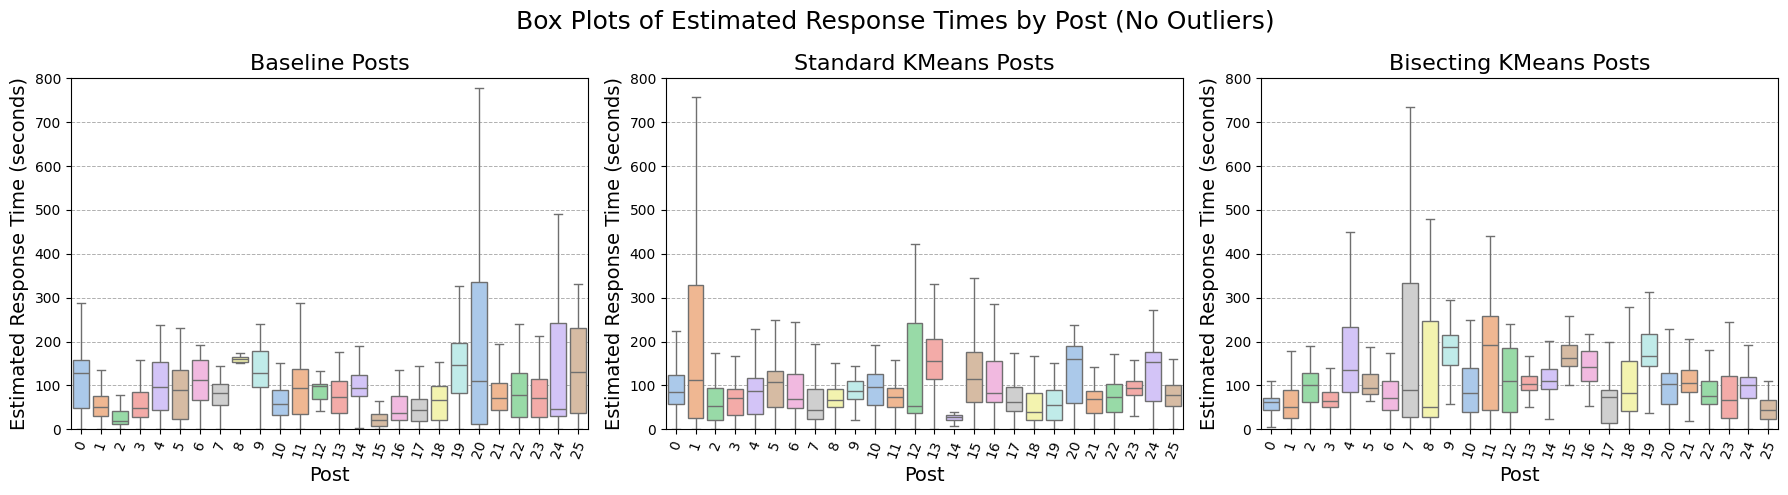

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.suptitle('Box Plots of Estimated Response Times by Post (No Outliers)', fontsize=18)
max_graph_y_val = 800

# Baseline
sns.boxplot(data=results_gdf.dropna(subset=['baseline_ert', 'baseline_post']),
            ax=axes[0],
            x='baseline_post',
            y='baseline_ert',
            palette='pastel',
            hue='baseline_post',
            showfliers=False,
            legend=False)

axes[0].set_title(f'Baseline Posts', fontsize=16)
axes[0].set_xlabel('Post', fontsize=14)
axes[0].set_ylabel('Estimated Response Time (seconds)', fontsize=14)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=70)
axes[0].set(ylim=(0, max_graph_y_val))

# Standard KMeans
sns.boxplot(data=results_gdf.dropna(subset=['std_kmeans_ert', 'std_kmeans_post']),
            ax=axes[1],
            x='std_kmeans_post',
            y='std_kmeans_ert',
            palette='pastel',
            hue='std_kmeans_post',
            showfliers=False,
            legend=False)

axes[1].set_title(f'Standard KMeans Posts', fontsize=16)
axes[1].set_xlabel('Post', fontsize=14)
axes[1].set_ylabel('Estimated Response Time (seconds)', fontsize=14)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=70)
axes[1].set(ylim=(0, max_graph_y_val))

# Bisecting KMeans
sns.boxplot(data=results_gdf.dropna(subset=['bisect_kmeans_ert', 'bisect_kmeans_post']),
            ax=axes[2],
            x='bisect_kmeans_post',
            y='bisect_kmeans_ert',
            palette='pastel',
            hue='bisect_kmeans_post',
            showfliers=False,
            legend=False)

axes[2].set_title(f'Bisecting KMeans Posts', fontsize=16)
axes[2].set_xlabel('Post', fontsize=14)
axes[2].set_ylabel('Estimated Response Time (seconds)', fontsize=14)
axes[2].grid(axis='y', linestyle='--', linewidth=0.7)
axes[2].tick_params(axis='x', rotation=70)
axes[2].set(ylim=(0, max_graph_y_val))

plt.tight_layout()
plt.show()

### Box Plots of Estimated Response Time by Priority

Bisecting KMeans is worse than baseline and standard KMeans, especially on priority 1 calls. The standard KMeans model shows a lower median and a tighter interquartile range than the others, regardless of priority, but does not show significant improvement in priority 1 calls. If improvement in priority 1 calls is important, we could try adjusting the sample weights function and/or including something related to priority 1 calls specifically in the objective function to try to get better results.


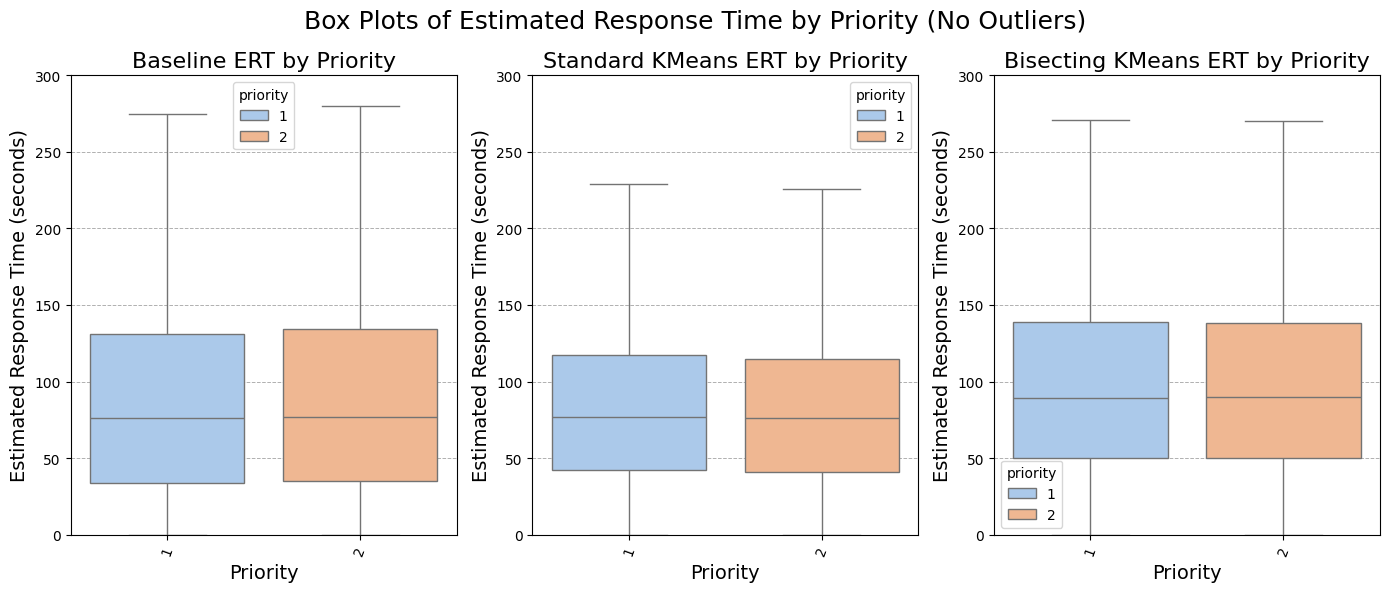

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
fig.suptitle('Box Plots of Estimated Response Time by Priority (No Outliers)', fontsize=18)
max_graph_y_val = 300

# Baseline
sns.boxplot(data=results_gdf.dropna(subset=['baseline_ert', 'priority']),
            ax=axes[0],
            x='priority',
            y='baseline_ert',
            palette='pastel',
            hue='priority',
            showfliers=False)

axes[0].set_title(f'Baseline ERT by Priority', fontsize=16)
axes[0].set_xlabel('Priority', fontsize=14)
axes[0].set_ylabel('Estimated Response Time (seconds)', fontsize=14)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7)
axes[0].tick_params(axis='x', rotation=70)
axes[0].set(ylim=(0, max_graph_y_val))

# Standard KMeans
sns.boxplot(data=results_gdf.dropna(subset=['std_kmeans_ert', 'priority']),
            ax=axes[1],
            x='priority',
            y='std_kmeans_ert',
            palette='pastel',
            hue='priority',
            showfliers=False)

axes[1].set_title(f'Standard KMeans ERT by Priority', fontsize=16)
axes[1].set_xlabel('Priority', fontsize=14)
axes[1].set_ylabel('Estimated Response Time (seconds)', fontsize=14)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7)
axes[1].tick_params(axis='x', rotation=70)
axes[1].set(ylim=(0, max_graph_y_val))

# Bisecting KMeans
sns.boxplot(data=results_gdf.dropna(subset=['bisect_kmeans_ert', 'priority']),
            ax=axes[2],
            x='priority',
            y='bisect_kmeans_ert',
            palette='pastel',
            hue='priority',
            showfliers=False)

axes[2].set_title(f'Bisecting KMeans ERT by Priority', fontsize=16)
axes[2].set_xlabel('Priority', fontsize=14)
axes[2].set_ylabel('Estimated Response Time (seconds)', fontsize=14)
axes[2].grid(axis='y', linestyle='--', linewidth=0.7)
axes[2].tick_params(axis='x', rotation=70)
axes[2].set(ylim=(0, max_graph_y_val))

plt.tight_layout()
plt.show()

### Cluster Maps of Coverage Areas

Plotting the calls onto a map of Cincinnati, the baseline and standard KMeans coverage areas are similar, with more distinct coverage areas in the 39.150, \-84.60 area.  There are several coverage areas in the baseline that are visibly larger, which may account for the difference in performance.  Bisecting KMeans coverage areas have high variance in size, which likely contributes to its poor performance.



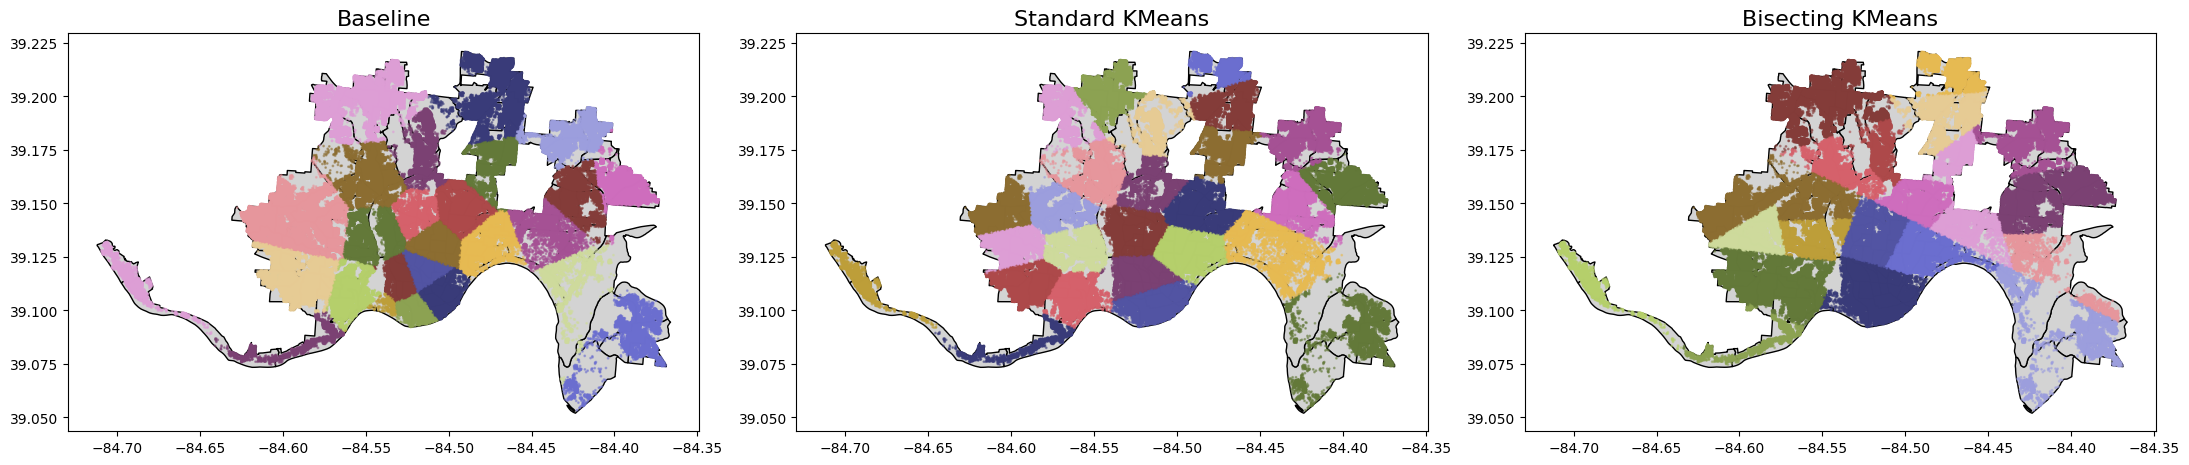

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 8))

cmap = plt.get_cmap('tab20b', 26)

shapefile_gdf.plot(ax=axes[0], color='lightgray', edgecolor='black')
results_gdf.plot(ax=axes[0], column='baseline_post', cmap=cmap, markersize=1, alpha=0.5, legend=False)
axes[0].set_title(f'Baseline', fontsize=16)

shapefile_gdf.plot(ax=axes[1], color='lightgray', edgecolor='black')
results_gdf.plot(ax=axes[1], column='std_kmeans_post', cmap=cmap, markersize=1, alpha=0.5, legend=False)
axes[1].set_title(f'Standard KMeans', fontsize=16)

shapefile_gdf.plot(ax=axes[2], color='lightgray', edgecolor='black')
results_gdf.plot(ax=axes[2], column='bisect_kmeans_post', cmap=cmap, markersize=1, alpha=0.5, legend=False)
axes[2].set_title(f'Bisecting KMeans', fontsize=16)

plt.tight_layout()
plt.show()

## Conclusions

This project examined the use of unsupervised machine learning, specifically K\-Means clustering, to optimize ambulance posting locations in Cincinnati based on historical EMS response data. Both the standard K\-Means and bisecting K\-Means algorithms were implemented, with Bayesian optimization used to fine\-tune parameters. The objective function aimed to minimize the average emergency response time \(ERT\) across a test set of incident data. The training set included the first four years of data, and the test set included the last year of data, simulating a field test.

The standard K\-Means model yielded a 5.09% reduction in mean response time and a 9.94% decrease in standard deviation compared to the baseline.  This improvement is likely due to K\-Means' ability to create relatively balanced cluster sizes while capturing high\-density regions effectively, ensuring ambulances are positioned closer to areas with frequent incidents.

Bisecting K\-Means performed poorly, resulting in an increase of 13.25% mean response time and 6.56% increase to standard deviation compared to baseline. This is likely due to the bisecting algorithm prioritizing the largest or most variable cluster at each step of its process. A higher density region may be split several times before the lower density areas begin to be split, creating large sparse areas and small dense ones. This behavior is observed in the cluster maps of coverage areas.

Using the standard K\-Means model's improvements, reducing mean response times directly enhances patient outcomes, as timely intervention is critical in medical emergencies. Equally important is minimizing variability in response times, particularly for the incidents at locations with the highest ERTs, where delays can have the most severe consequences. By addressing both average and extreme response times, this approach contributes to a more effective and equitable EMS system. The improvement to the 75th percentile of ERT of 12.12% shows that the most dramatic improvements come in this critical window.


### Future Research

The modest improvements achieved highlight the complexity of optimizing ambulance deployment. One problem with the KMeans models that were implemented in this project is that the model itself iterates using an algorithm that evaluates based on the euclidean distances of the coordinates. I then try to influence the model by optimizing over the lambda parameter and the random\_state using the average ERT as the minimization objective. The model works because euclidean distance is a pretty good estimate for travel time \(or ERT\), and the minimization objective technique can influence it somewhat. However, the influence is indirect and minimal. It would be better if the KMeans algorithm worked directly on the ERT.

There are two strategies I would try in the future to improve upon the process.

1. Use a KMeans model as a starting point for ambulance locations, and then use other algorithms, such as a genetic algorithm or partical swarm optimization, to improve ERT and possibly other metrics as well. This would be particularly useful if the number of posting locations is inflexible due to resource limitations. As we have seen, the KMeans model will find a fairly smart starting point using euclidean distance given the desired number of posting locations as n\_clusters.
2. Use the [KMedoids model from sklearn\_extra](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html). This model uses actual datapoints as centers, and is able to use alternative distance metrics to euclidean distance. The idea would be to use a precomputed travel time matrix with this model. The matrix would need to be a node\-to\-node travel distance of our entire Cincinnati graph, and the features would need to be converted to nodes before being input into the model. Obviously, calculating the travel times distance matrix would require some careful thought and may be computationally expensive. However, this would be the most direct way to attack the problem and would certainly be an interesting experiment.

